## 训练前处理

* 完成分割验证集
* 完成几种常见的数据增强
* 完成简单的数据迭代器

### 1. 制作验证集
***

虽然交叉验证能利用所有的训练数据，但过于费时，前期应保持快速的模型迭代过程，所以直接随机取训练集的10%作为验证集,来测试训练模型的效果

### 接着上次视频，将训练集 随机抽10%作为验证集

In [1]:
import glob
import os
import shutil
import random
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
fpaths  = glob.glob(r'F:\RSNA\data\train\*.npy')

In [3]:
len(fpaths)

5093

In [12]:
fpaths[:10]

['F:\\RSNA\\data\\train\\00436515-870c-4b36-a041-de91049b9ab4.npy',
 'F:\\RSNA\\data\\train\\00704310-78a8-4b38-8475-49f4573b2dbb.npy',
 'F:\\RSNA\\data\\train\\00aecb01-a116-45a2-956c-08d2fa55433f.npy',
 'F:\\RSNA\\data\\train\\00c0b293-48e7-4e16-ac76-9269ba535a62.npy',
 'F:\\RSNA\\data\\train\\00f08de1-517e-4652-a04f-d1dc9ee48593.npy',
 'F:\\RSNA\\data\\train\\0100515c-5204-4f31-98e0-f35e4b00004a.npy',
 'F:\\RSNA\\data\\train\\010ccb9f-6d46-4380-af11-84f87397a1b8.npy',
 'F:\\RSNA\\data\\train\\012a5620-d082-4bb8-9b3b-e72d8938000c.npy',
 'F:\\RSNA\\data\\train\\0174c4bb-28f5-41e3-a13f-a396badc18bd.npy',
 'F:\\RSNA\\data\\train\\019d950b-dd38-4cf3-a686-527a75728be6.npy']

In [13]:
#随机打乱 列表
random.shuffle(fpaths)

* 对后面的10%的数据化为验证集

In [14]:
valid_fpaths = fpaths[int(0.9*len(fpaths)):]

In [15]:
len(valid_fpaths)

566

In [16]:
#移动验证集
for path in valid_fpaths:
    npath = path.replace('train','valid')
    shutil.move(path,npath)

### 2. 数据增强
***

数据增强能显著提高模型泛化能力，考虑到胸片数据都是正面拍摄，所以这里考虑的2种增强的方法有：
* 小角度（-10,10）degree 的旋转
* 上下左右位移，幅度在5%内
* 其他增强方法后续考察。

旋转和位移以及其他涉及到图像移动的增强方法，bbox或者mask应该保持相同的位置变换


In [4]:
import cv2
import numpy as np

###### rotation

In [8]:
data = np.load(fpaths[0]).item()

image = data['image']
bboxs = data['bboxs']

#### 这里使用opencv的仿射变换

In [25]:
height, width = image.shape[:2]
center = width//2,height//2 #中心坐标
degree = -45
#得到以图像中心坐标的旋转角度为degrees的放射矩阵
mat = cv2.getRotationMatrix2D(center,angle=degree,scale=1.) #affine matrix
#对图像进行仿射变换
out_image = cv2.warpAffine(image,mat,(width,height))

#### #对bbox的坐标也要做相应的仿射变换


In [26]:

out_bboxs = bboxs.copy()
t_bboxs =  bboxs.copy()
#注意： 这里不只是变化左上角和右下角的坐标，对右上角和左下角也做了变换
out_bboxs = np.hstack((out_bboxs,out_bboxs[:,[0,3,2,1]]))
out_bboxs = out_bboxs.reshape(-1,2)
out_bboxs = np.hstack((out_bboxs,np.ones((len(out_bboxs),1)))).T[[1,0,2]]
#上述步骤：将bbox的数组变化为3*8n的形状，每一列向量是 x,y,1
#这样就可以与仿射变化矩阵相乘了
out_bboxs = np.dot(mat,out_bboxs)
#重新变化下形状
out_bboxs = out_bboxs[[1,0]].T.reshape(-1,8)
out_bboxs

array([[  82.07907704,  591.19595949,  500.6862915 ,  473.81623382,
         232.69282143,  741.80970389,  350.07254711,  323.20248942],
       [ 292.79689783,  801.91378029,  794.13560569,  662.61374439,
         473.81623382,  982.93311627,  613.11626971,  481.59440841]])

旋转后，应该取bboxs四个角的坐标的最小值作为左上角坐标，最大值作为右下角坐标

In [27]:

t_bboxs[:,0],t_bboxs[:,2] = np.min(out_bboxs[:,[0,2,4,6]],axis=1),np.max(out_bboxs[:,[0,2,4,6]],axis=1)
t_bboxs[:,1],t_bboxs[:,3] = np.min(out_bboxs[:,[1,3,5,7]],axis=1),np.max(out_bboxs[:,[1,3,5,7]],axis=1)
t_bboxs

array([[  82.07907704,  323.20248942,  500.6862915 ,  741.80970389],
       [ 292.79689783,  481.59440841,  794.13560569,  982.93311627]])

#### 让我们看看结果

In [28]:

def visulize(img,bboxs):
    copy_image = img.copy()
    for bbox in  bboxs:
        cv2.rectangle(copy_image,(int(bbox[1]),int(bbox[0])),(int(bbox[3]),int(bbox[2])),[0,255,0],4)
    plt.imshow(copy_image,'gray')

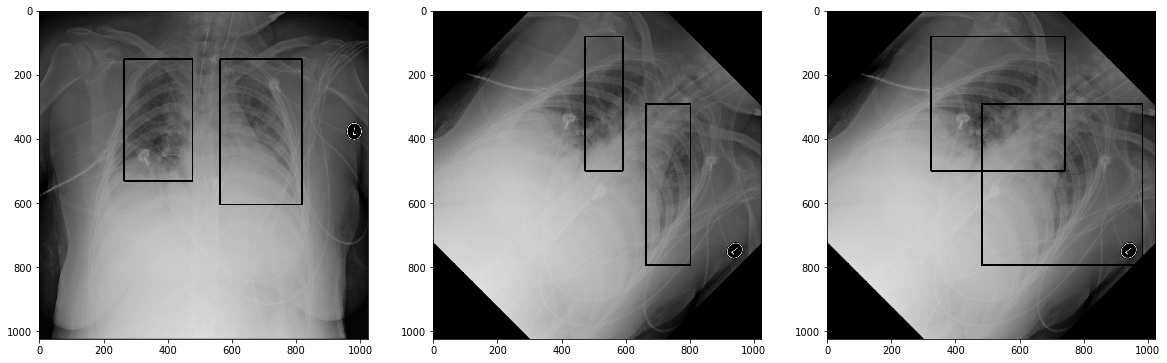

In [29]:
plt.figure(figsize=(20,20))
plt.subplot(131)
visulize(image,bboxs)
plt.subplot(132)
visulize(out_image,out_bboxs)#如果只是变化左上角和右下角坐标的会出现这种情况，如果旋转角度小，到影响不道，45度影响最大，90度反而一样了 
plt.subplot(133)
visulize(out_image,t_bboxs)

In [30]:
#封装为函数
def affine_bbox(mat,bboxs):
    out_bboxs = bboxs.copy()
    t_bboxs =  bboxs.copy()
    out_bboxs = np.hstack((out_bboxs,out_bboxs[:,[0,3,2,1]]))
    out_bboxs = out_bboxs.reshape(-1,2)
    out_bboxs = np.hstack((out_bboxs,np.ones((len(out_bboxs),1)))).T[[1,0,2]]
    out_bboxs = np.dot(mat,out_bboxs)
    out_bboxs = out_bboxs[[1,0]].T.reshape(-1,8)
    t_bboxs[:,0],t_bboxs[:,2] = np.min(out_bboxs[:,[0,2,4,6]],axis=1),np.max(out_bboxs[:,[0,2,4,6]],axis=1)
    t_bboxs[:,1],t_bboxs[:,3] = np.min(out_bboxs[:,[1,3,5,7]],axis=1),np.max(out_bboxs[:,[1,3,5,7]],axis=1)
    #clip
    t_bboxs[:,[0,2]] = np.clip(t_bboxs[:,[0,2]],0,height)
    t_bboxs[:,[1,3]] = np.clip(t_bboxs[:,[1,3]],0,width)
    return t_bboxs

In [31]:
def rotation(image,bboxs,rotation_range=(-10,10),prob=0.8):
    if random.random() > prob:
        return image,bboxs
    degree = random.uniform(*rotation_range)
#     print(degree)
    height, width = image.shape[:2]
    center = width//2,height//2
    #rotation image
    mat = cv2.getRotationMatrix2D(center,angle=degree,scale=1.) #affine matrix
    out_image = cv2.warpAffine(image,mat,(width,height))
    #rotation bbox
    out_bboxs = affine_bbox(mat,bboxs)
    return out_image,out_bboxs

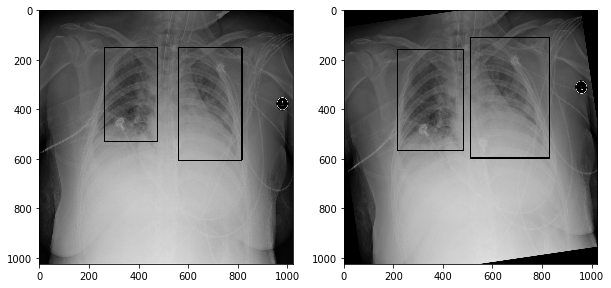

In [32]:
out_image,t_bboxs = rotation(image,bboxs)
plt.figure(figsize=(10,10))
plt.subplot(121)
visulize(image,bboxs)
plt.subplot(122)
visulize(out_image,t_bboxs)

###### 位移shift 

In [33]:
#位移很简单
def shift(image,bboxs,shift_range=0.1,prob=0.8):
    if random.random() > prob:
        return image,bboxs
    height, width = image.shape[:2]
    dy = height*random.uniform(-1,1)*shift_range
    dx = width*random.uniform(-1,1)*shift_range
    #rotation image
    mat = np.array([[1,0,dx],
                    [0,1,dy]],dtype=np.float32) #affine matrix
    out_image = cv2.warpAffine(image,mat,(width,height))
    #rotation bbox
    out_bboxs = affine_bbox(mat,bboxs)
    return out_image,out_bboxs

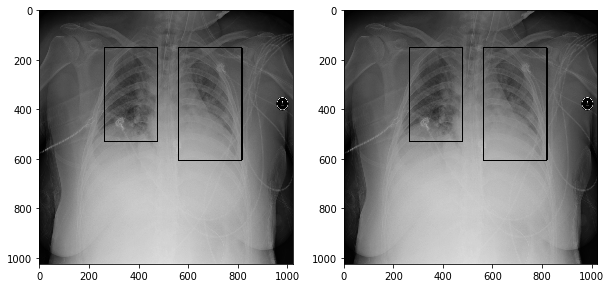

In [34]:
out_image,t_bboxs = shift(image,bboxs,0.1)
plt.figure(figsize=(10,10))
plt.subplot(121)
visulize(image,bboxs)
plt.subplot(122)
visulize(out_image,t_bboxs)

### 其他的数据增强方法

### 我没有使用voc数据格式，喜欢自己写自己的数据生成器

### 3.数据迭代器
***
完成简单的数据迭代器，实现__getitem__()方法，支持索引和切片，然后用torchvison的dataloader即可完成训练数据迭代器

* 完成resize
* 完成normalize

In [35]:
#实际不一样
class Datasets:
    def __init(self,Dir,phase):
        self.fpaths = glob.glob(f'{Dir}/{phase}/*.npy')
        self.phase = phase
        self.transform = Transform(opt.min_size, opt.max_size) #参考项目
    def __getitem__(self,index):
        path = self.fpaths[index]
        data = np.load(fpaths[0]).item()
        image = data['image']
        #灰度格式需要转化为RGB格式
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        bboxs = data['bboxs'].astype(np.float32)
        label = np.array([1])
        if self.phase == 'train':
            image,bboxs = rotation(image,bboxs,rotation_range=(-10, 10), prob=0.6)
            image,bboxs = shift(image,bboxs,rotation_range=(-10, 10), prob=0.6)
            #使用torch，通道维度的位置在先
            image = image.transpose((2,0,1)).astype(np.float32)
            #这里的transform是下面fasterRCNN自带的预处理和归一化方法
            image, bboxs, label, scale = self.transform((image, bboxs, label))
            return image.copy(), bboxs.copy(), label.copy(), scale
        else:
            image = image.transpose((2,0,1)).astype(np.float32)
            t_img = preprocess(image)
            t_img = t_img.astype(np.float32)
            return t_img, image.shape[1:], bboxs, label
    def __len__(self):
        return len(self.fpaths)

### 4.FasterRCNN初体验
***
感谢chenyuntc提供的fasterRCNN代码， https://github.com/chenyuntc/simple-faster-rcnn-pytorch , 

* 将上面代码集成到该项目里，开始训练
* 明天出结果

#### 我没有使用数据增强的方法，训练了下，结果不是特比理想
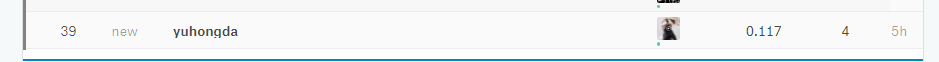

### TODO

#### 将会做一系列的尝试，有好的结果，后续将会继续视频